In [1]:
!pip install pycaret

     |████████████████████████████████| 266 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 37.3 MB/s eta 0:00:01
     |████████████████████████████████| 14.6 MB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 24.2 MB 44.1 MB/s eta 0:00:01
     |████████████████████████████████| 167 kB 59.0 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 53.8 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 7.8 MB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 58.6 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 4.6 MB/s  eta 0:00:01
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=57b1b0a80e9f72257c7929731df845d6fec1b7d331bcea08605eeeb45e404420
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.15.0-py3-none-any.whl size=105260 sha256=e36680126d6c

In [2]:
import json
import math
import os
import cv2
import pickle
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pycaret
from pycaret.classification import *
import xgboost as xgb

from tqdm import tqdm, tqdm_notebook

from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge,Xception, InceptionResNetV2, NASNetMobile
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPool2D, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model, model_from_json, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import tensorflow as tf
import gc
from functools import partial

from sklearn import metrics
from sklearn.utils import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats

from warnings import filterwarnings
filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

from collections import Counter
import json
import itertools
%matplotlib inline

2021-09-30 11:02:45.518811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


### Step2: Image Classification using InceptionV3 + XgBoost

#### The 7 classes of skin cancer lesions included in this dataset are:

#### Melanocytic nevi (nv)
#### Melanoma (mel)
#### Benign keratosis-like lesions (bkl)
#### Basal cell carcinoma (bcc) 
#### Actinic keratoses (akiec)
#### Vascular lesions (vas)
#### Dermatofibroma (df)

In [5]:
skin_df = pd.read_csv('../input/data-ham10000/Dataverse/HAM10000_metadata.csv')
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [11]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [12]:
segmented_image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../input/data-ham10000/Dataverse/all_segmented_images', '*.png'))}
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../input/data-ham10000/Dataverse/HAM10000_images', '*.jpg'))}

In [13]:
skin_df['segmented_image_id'] = skin_df.agg(lambda x: f"{x['image_id']}_masked", axis=1)

skin_df['segmented_image_path'] = skin_df['segmented_image_id'].map(segmented_image_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['label'] = pd.Categorical(skin_df['cell_type']).codes

In [14]:
skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

    segmented_image_id                               segmented_image_path  \
0  ISIC_0027419_masked  ../input/data-ham10000/Dataverse/all_segmented...   
1  ISIC_0025030_masked  ../input/data-ham10000/Dataverse/all_segmented...   
2  ISIC_0026769_masked  ../input/data-ham10000/Dataverse/all_segmented...   
3  ISIC_0025661_masked  ../input/data-ham10000/Dataverse/all_segmented...   
4  ISIC_0031633_masked  ../input/data-ham10000/Dataverse/all_segmented...   

                       cell_type  label  
0  Benign keratosis-like lesions      2  
1  Benign keratosis-like lesions      2  
2  Benign keratosis-like lesions      2  
3  Benign keratosis-like lesions      2  
4  Benign keratosis-like lesions      2

In [16]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lesion_id             10015 non-null  object 
 1   image_id              10015 non-null  object 
 2   dx                    10015 non-null  object 
 3   dx_type               10015 non-null  object 
 4   age                   9958 non-null   float64
 5   sex                   10015 non-null  object 
 6   localization          10015 non-null  object 
 7   segmented_image_id    10015 non-null  object 
 8   segmented_image_path  10015 non-null  object 
 9   cell_type             10015 non-null  object 
 10  label                 10015 non-null  int8   
dtypes: float64(1), int8(1), object(9)
memory usage: 792.3+ KB


#### Data Distribution

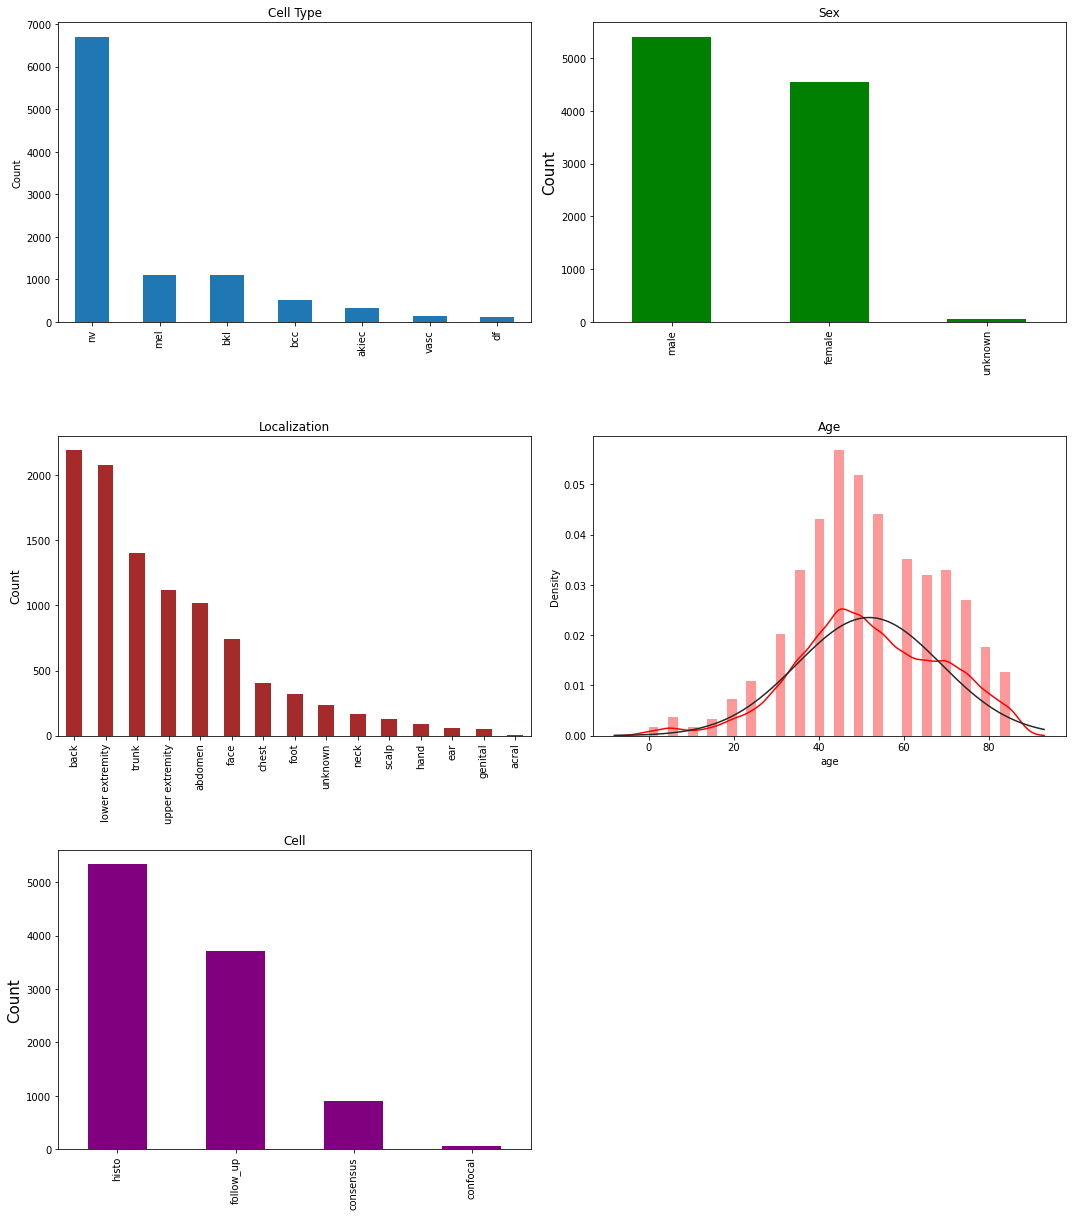

In [20]:
	5
# Data distribution visualization
fig = plt.figure(figsize=(15,17))

ax1 = fig.add_subplot(321)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(322)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2, color = 'green')
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(323)
skin_df['localization'].value_counts().plot(kind='bar', color = 'brown')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(324)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

ax5 = fig.add_subplot(325)
skin_df['dx_type'].value_counts().plot(kind='bar', ax=ax5, color = 'purple')
ax5.set_ylabel('Count', size=15)
ax5.set_title('Cell');

plt.tight_layout()
plt.savefig('Data_Distribution.jpg')
plt.show()

#### Distribution of Data according to the 7 classes

In [15]:
# Distribution of data into various classes 
print(skin_df['cell_type'].value_counts())

Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: cell_type, dtype: int64


#### Data is highly imbalanced
#### Using Resampling techniques to balance the image data

In [18]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=600  #Resampling to 600 images
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, 
                              df_6_balanced])

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
skin_df_balanced['cell_type'].value_counts()

Vascular lesions                 600
Basal cell carcinoma             600
Benign keratosis-like lesions    600
Actinic keratoses                600
Melanoma                         600
Dermatofibroma                   600
Melanocytic nevi                 600
Name: cell_type, dtype: int64

#### Adding image data to the balanced dataframe

In [19]:
skin_df_balanced['segmented_image'] = skin_df_balanced['segmented_image_path'].map(lambda x: np.asarray(Image.open(x).resize((128,128))))

In [69]:
skin_df_balanced.head()

lesion_id      image_id     dx dx_type   age   sex     localization  \
9789  HAM_0003136  ISIC_0026645  akiec   histo  65.0  male             back   
9957  HAM_0006587  ISIC_0025780  akiec   histo  70.0  male             face   
9793  HAM_0005505  ISIC_0024450  akiec   histo  50.0  male  upper extremity   
9758  HAM_0003455  ISIC_0027896  akiec   histo  75.0  male             hand   
9875  HAM_0005459  ISIC_0029268  akiec   histo  85.0  male  upper extremity   

       segmented_image_id                               segmented_image_path  \
9789  ISIC_0026645_masked  ../input/data-ham10000/Dataverse/all_segmented...   
9957  ISIC_0025780_masked  ../input/data-ham10000/Dataverse/all_segmented...   
9793  ISIC_0024450_masked  ../input/data-ham10000/Dataverse/all_segmented...   
9758  ISIC_0027896_masked  ../input/data-ham10000/Dataverse/all_segmented...   
9875  ISIC_0029268_masked  ../input/data-ham10000/Dataverse/all_segmented...   

              cell_type  label  \
9789  Actinic keratoses      0   
9957  Actinic keratoses      0   
9793  Actinic keratoses      0   
9758  Actinic keratoses      0   
9875  Actinic keratoses      0   

                                        segmented_image  
9789  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
9957  [[[136, 76, 84], [139, 80, 87], [131, 67, 69],...  
9793  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
9758  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
9875  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

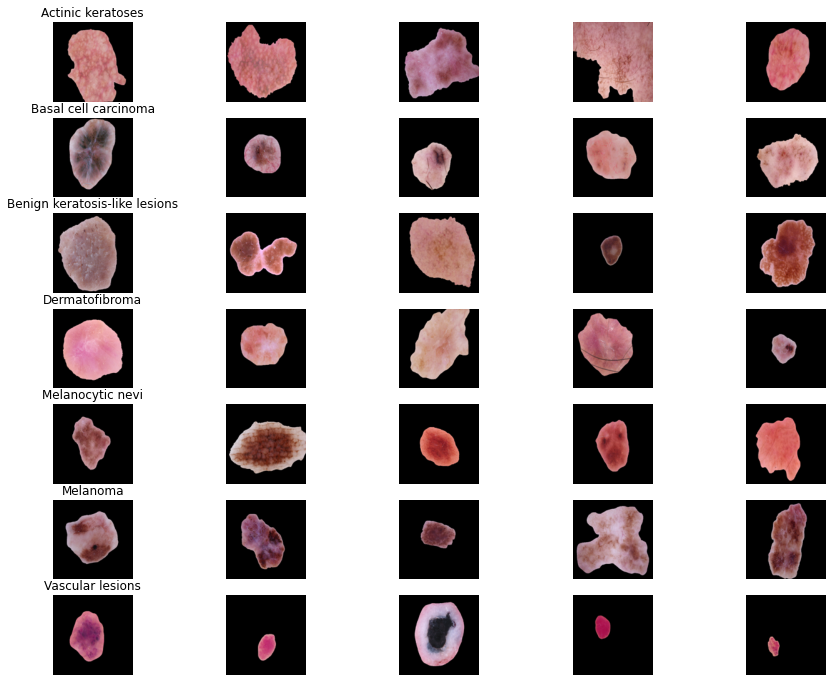

In [21]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (3*n_samples, 2*6))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['segmented_image'])
        c_ax.axis('off')
        
plt.savefig('Class_images.jpg')

#### Getting X and y data for training
#### Where X -> segmented images and y -> Labels

In [23]:
X = skin_df_balanced['segmented_image']
X = X.values
X = X/255

lst = []
for _ in X:
    lst.append(_)
X = np.array(lst)

print("Shape of X : {}".format(X.shape))

Shape of X : (4200, 128, 128, 3)


In [25]:
y = skin_df_balanced['label']
print("Shape of y : {}".format(y.shape))

Shape of y : (4200,)


In [27]:
# Splitting X, y into x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=28)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3150, 128, 128, 3), (1050, 128, 128, 3), (3150,), (1050,))

In [28]:
# Splitting x_train, y_train into x_train, x_val, y_train, y_val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20,random_state=28)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((2520, 128, 128, 3), (630, 128, 128, 3), (2520,), (630,))

In [39]:
y_test = to_categorical(y_test, num_classes = 7)

In [29]:
# Converting target variables to categorical
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

print("Shape of y_val : {}".format(y_val.shape))

Shape of y_val : (630, 7)


#### Defining some model parameters

In [30]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

optimizer = Adam(lr=0.0001)

#### Defining model structure

In [31]:
def baseStructure(base_model):
    # Add layers at the end
    model = base_model.output
    model = Flatten()(model)

    model = Dense(512, kernel_initializer='he_uniform')(model)
    model = Dropout(0.2)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    model = Dense(128, kernel_initializer='he_uniform')(model)
    model = Dropout(0.2)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    model = Dense(52, kernel_initializer='he_uniform')(model)
    model = Dropout(0.2)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    model = Dense(16, kernel_initializer='he_uniform')(model)
    model = Dropout(0.2)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    output = Dense(n_classes, activation='softmax')(model)
    
    return output

#### Using InceptionV3 model

In [33]:
batch_size = 256
train_input_shape = (128, 128, 3)
n_classes = 7

base_model = InceptionV3(include_top = False , input_shape = train_input_shape)


for layer in base_model.layers:
    layer.trainable = True
    
    
output = baseStructure(base_model)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

2021-09-30 11:22:31.370110: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-30 11:22:31.370493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 11:22:31.371506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-30 11:22:31.371768: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-30 11:22:31.371838: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-30 11:22:31.371882: I tensorflow/stream_executor/platform/

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_____________________________

In [34]:
plot_model(model, to_file='InceptionV3_model.png', show_shapes=True, show_layer_names=True)

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

#### Training on the proposed model

In [36]:
history = model.fit(x_train, 
                    y_train,
                    epochs=50,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val))

2021-09-30 11:24:05.903648: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 495452160 exceeds 10% of free system memory.
2021-09-30 11:24:06.365288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-30 11:24:06.380727: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz


Epoch 1/50


2021-09-30 11:24:13.661207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-30 11:24:14.666330: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-30 11:24:14.711344: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


79/79 [==============================] - 24s 117ms/step - loss: 2.0948 - accuracy: 0.1714 - val_loss: 2.3276 - val_accuracy: 0.2079
Epoch 2/50
79/79 [==============================] - 6s 78ms/step - loss: 1.8470 - accuracy: 0.2777 - val_loss: 2.0146 - val_accuracy: 0.3270
Epoch 3/50
79/79 [==============================] - 6s 79ms/step - loss: 1.6541 - accuracy: 0.3788 - val_loss: 1.4964 - val_accuracy: 0.4952
Epoch 4/50
79/79 [==============================] - 6s 79ms/step - loss: 1.5142 - accuracy: 0.4836 - val_loss: 1.4183 - val_accuracy: 0.5619
Epoch 5/50
79/79 [==============================] - 6s 79ms/step - loss: 1.3884 - accuracy: 0.5639 - val_loss: 1.3092 - val_accuracy: 0.6571
Epoch 6/50
79/79 [==============================] - 6s 82ms/step - loss: 1.2945 - accuracy: 0.6093 - val_loss: 1.2301 - val_accuracy: 0.6841
Epoch 7/50
79/79 [==============================] - 6s 79ms/step - loss: 1.1745 - accuracy: 0.6919 - val_loss: 1.1726 - val_accuracy: 0.7238
Epoch 8/50
79/79 [====

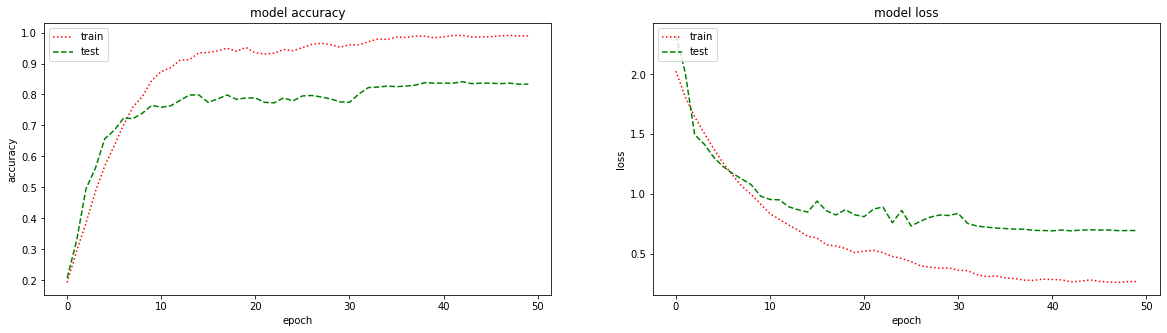

In [37]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], linestyle='dotted', color='red')
plt.plot(history.history['val_accuracy'], linestyle='dashed', color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], linestyle='dotted', color='red')
plt.plot(history.history['val_loss'], 'green', linestyle='dashed', color='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
print('\n~~~~~~~~~~~~~~~Stats after 50 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
score = model.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('Accuracy:  |   {:.2f}  |'.format(score[1]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
score = model.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('Accuracy:  |   {:.2f}  |'.format(score[1]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
score = model.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('Accuracy:  |   {:.2f}  |'.format(score[1]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 50 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

140/140 [==============================] - 3s 20ms/step - loss: 0.0771 - accuracy: 1.0000
________________________
Accuracy:  |   100.00  |
________________________

-------------On Test  Set--------------------------

59/59 [==============================] - 1s 20ms/step - loss: 0.7333 - accuracy: 0.8124
________________________
Accuracy:  |   81.24  |
________________________

-------------On validation Set---------------------

35/35 [==============================] - 1s 20ms/step - loss: 0.6933 - accuracy: 0.8333
________________________
Accuracy:  |   83.33  |
________________________


#### Predictions on test data

In [59]:
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

#### Classification Report of InceptionV3

In [60]:
# Generating a classification report
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(y_true, y_pred_classes, target_names=targetnames))

              precision    recall  f1-score   support

       akiec       0.81      0.85      0.83       156
         bcc       0.83      0.84      0.84       156
         bkl       0.64      0.75      0.69       146
          df       0.91      0.97      0.94       151
         mel       0.77      0.66      0.71       139
          nv       0.75      0.62      0.68       152
        vasc       0.97      0.99      0.98       150

    accuracy                           0.81      1050
   macro avg       0.81      0.81      0.81      1050
weighted avg       0.81      0.81      0.81      1050



#### Confusion Matrix of InceptionV3

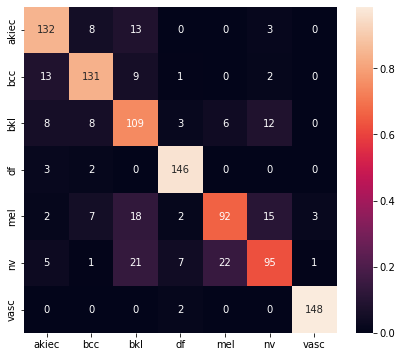

In [61]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

def plot_confusion_matrix(cm, classes, normalized=True):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes)
        
plot_confusion_matrix(cm, targetnames)

#### Incorrect Predictions

Text(0, 0.5, 'Fraction of incorrect predictions')

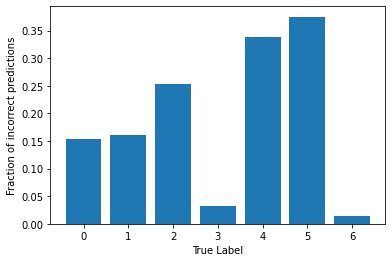

In [62]:
#PLotting fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [47]:
# Saving the Xception Model
model.save('InceptionV3_Usedmodel_83acc.h5')

<h3><a href="InceptionV3_Usedmodel_83acc.h5"> Download the above used InceptionV3 model </a></h3>

#### Saving the model into new model for feature extraction

In [48]:
model2 = Model(model.input, model.layers[-7].output)   # Removing Last 7 layers
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [49]:
plot_model(model2, to_file='FeatureExtraction_InceptionV3_model.png', show_shapes=True, show_layer_names=True)

#### Predicting feature of all images

In [64]:
predictions = model2.predict(X)

In [65]:
predictions[10]       # Predicting features of image at index 10

array([-1.3456497 , -1.5976677 , -1.1304189 ,  0.5420284 ,  2.323205  ,
       -1.0338128 , -0.8209578 ,  0.85930264, -0.26878077,  0.07187897,
       -0.5850891 , -0.18146217, -0.8796809 , -0.49656087,  1.7302272 ,
       -1.1581589 , -0.6731813 , -0.8305272 , -0.30877316, -0.8738985 ,
        1.2657887 , -0.468807  , -1.4044315 , -0.11065054,  0.88540196,
       -0.6701052 ,  2.0994728 , -0.5485586 ,  1.2619439 , -1.6003864 ,
        1.3121399 , -1.011245  ,  2.1554096 , -0.91325235,  1.4763495 ,
        1.5664486 , -0.8739977 , -0.95441926, -0.88351715,  0.6221856 ,
       -0.42302227, -1.245949  , -0.79014504, -0.9199867 ,  0.2303089 ,
       -0.5291654 , -0.5621233 ,  1.1669848 , -0.51981413,  0.5932082 ,
       -0.84283394, -1.6005669 ], dtype=float32)

#### Saving the new model

In [66]:
### saving a model!!!!!

model_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)

In [67]:
model2.save("Second_InceptionV3_model.h5")
print("Saved model to disk")
model2.save_weights("model2_weights.h5")
print("Saved model to disk")

Saved model to disk
Saved model to disk


#### Concatinating Dataframe with the features extracted

In [72]:
skin_df_balanced = skin_df_balanced.reset_index()
skin_df_balanced.head()

index    lesion_id      image_id     dx dx_type   age   sex  \
0   9789  HAM_0003136  ISIC_0026645  akiec   histo  65.0  male   
1   9957  HAM_0006587  ISIC_0025780  akiec   histo  70.0  male   
2   9793  HAM_0005505  ISIC_0024450  akiec   histo  50.0  male   
3   9758  HAM_0003455  ISIC_0027896  akiec   histo  75.0  male   
4   9875  HAM_0005459  ISIC_0029268  akiec   histo  85.0  male   

      localization   segmented_image_id  \
0             back  ISIC_0026645_masked   
1             face  ISIC_0025780_masked   
2  upper extremity  ISIC_0024450_masked   
3             hand  ISIC_0027896_masked   
4  upper extremity  ISIC_0029268_masked   

                                segmented_image_path          cell_type  \
0  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
1  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
2  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
3  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
4  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   

   label                                    segmented_image  
0      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1      0  [[[136, 76, 84], [139, 80, 87], [131, 67, 69],...  
2      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

In [73]:
complete_data = pd.concat([skin_df_balanced, pd.DataFrame(predictions)], axis=1)
complete_data.head()

index    lesion_id      image_id     dx dx_type   age   sex  \
0   9789  HAM_0003136  ISIC_0026645  akiec   histo  65.0  male   
1   9957  HAM_0006587  ISIC_0025780  akiec   histo  70.0  male   
2   9793  HAM_0005505  ISIC_0024450  akiec   histo  50.0  male   
3   9758  HAM_0003455  ISIC_0027896  akiec   histo  75.0  male   
4   9875  HAM_0005459  ISIC_0029268  akiec   histo  85.0  male   

      localization   segmented_image_id  \
0             back  ISIC_0026645_masked   
1             face  ISIC_0025780_masked   
2  upper extremity  ISIC_0024450_masked   
3             hand  ISIC_0027896_masked   
4  upper extremity  ISIC_0029268_masked   

                                segmented_image_path          cell_type  \
0  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
1  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
2  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
3  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
4  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   

   label                                    segmented_image         0  \
0      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.034228   
1      0  [[[136, 76, 84], [139, 80, 87], [131, 67, 69],... -1.081139   
2      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.573319   
3      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -0.674555   
4      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -0.653552   

          1         2         3         4         5         6         7  \
0 -0.946425 -1.134811  0.630091  2.258219 -0.719998 -0.805317  0.603783   
1 -1.110284 -0.903940  0.632697  2.038860 -0.781017 -0.665455  0.661017   
2 -1.941421 -1.459885  0.585277  2.537544 -1.238211 -0.845466  0.619775   
3 -1.113554 -0.637149  0.753366  1.936854 -0.713565 -0.714652  0.487305   
4 -0.560507 -0.636536  0.691991  0.789632  0.628442 -0.148722  0.074360   

          8         9        10        11        12        13        14  \
0 -0.597661  0.018498 -0.471456  0.019673 -0.683881 -0.656001  1.709717   
1 -0.455992 -0.075559 -0.710985 -0.187541 -0.670103 -0.439278  1.711513   
2 -0.591504  0.207644 -0.680415 -0.186131 -0.905503 -0.363948  2.097454   
3 -0.303884 -0.106479 -0.479989 -0.266637 -0.646304 -0.537600  1.409105   
4 -0.230247 -0.010301 -0.075958 -0.128261 -0.483298 -0.137906  1.090442   

         15        16        17        18        19        20        21  \
0 -0.818456 -0.533067 -0.719779 -0.393422 -0.649492  1.078941 -0.573420   
1 -1.138685 -0.626899 -0.536276 -0.248138 -0.453967  1.057319 -0.474568   
2 -1.137853 -0.917731 -0.842749 -0.446478 -1.035597  1.444179 -0.688945   
3 -0.836921 -0.411019 -0.601717 -0.203118 -0.422172  0.752836 -0.449542   
4 -0.334552 -0.356615 -0.701171  0.598356  0.641295  0.605157 -0.228490   

         22        23        24        25        26        27        28  \
0 -1.109736 -0.050716  1.165878 -0.690010  1.935043 -0.363062  0.999991   
1 -1.287031 -0.068140  0.985189 -0.647063  1.898546 -0.683851  1.142969   
2 -1.402037 -0.299801  0.864473 -0.797674  2.149390 -0.688233  1.282149   
3 -1.241031 -0.107212  0.678638 -0.546620  1.406305 -0.478536  0.905922   
4 -0.841747  0.570263  0.276649 -0.996653  0.783785 -0.461537  0.760206   

         29        30        31        32        33        34        35  \
0 -1.151028  1.086487 -0.894871  2.156863 -0.655591  1.439069  1.352613   
1 -1.119244  1.041124 -0.861651  2.115341 -0.890133  1.490088  1.382882   
2 -1.686704  1.258880 -1.024979  2.426017 -1.021143  1.586444  1.783809   
3 -1.043189  1.062841 -0.652306  1.626853 -0.462449  1.226798  1.139766   
4 -0.052301  0.387546  0.350713  0.677715  0.316491  1.064826  0.723612   

         36        37        38        39        40        41        42  \
0 -0.888778 -0.719845 -0.773573  0.916522 -0.232851 -0.993017 -0.781580   
1 -0.637961 -0.955306 -0.745593  0.539901 -0.267337 

In [75]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 65 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4200 non-null   int64  
 1   lesion_id             4200 non-null   object 
 2   image_id              4200 non-null   object 
 3   dx                    4200 non-null   object 
 4   dx_type               4200 non-null   object 
 5   age                   4183 non-null   float64
 6   sex                   4200 non-null   object 
 7   localization          4200 non-null   object 
 8   segmented_image_id    4200 non-null   object 
 9   segmented_image_path  4200 non-null   object 
 10  cell_type             4200 non-null   object 
 11  label                 4200 non-null   int8   
 12  segmented_image       4200 non-null   object 
 13  0                     4200 non-null   float32
 14  1                     4200 non-null   float32
 15  2                    

#### Cleaning Data

In [76]:
dxtype_df=pd.get_dummies(complete_data['dx_type'],drop_first=False)
complete_data=pd.concat([dxtype_df,complete_data],axis=1)

localization_df=pd.get_dummies(complete_data['localization'],drop_first=False)
complete_data=pd.concat([localization_df,complete_data],axis=1)

sex_df=pd.get_dummies(complete_data['sex'],drop_first=False)
sex_df.drop(['unknown'],axis=1,inplace=True)
complete_data=pd.concat([sex_df,complete_data],axis=1)

complete_data.head()

female  male  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
0       0     1        0      0     1      0    0     0     0        0     0   
1       0     1        0      0     0      0    0     1     0        0     0   
2       0     1        0      0     0      0    0     0     0        0     0   
3       0     1        0      0     0      0    0     0     0        0     1   
4       0     1        0      0     0      0    0     0     0        0     0   

   lower extremity  neck  scalp  trunk  unknown  upper extremity  confocal  \
0                0     0      0      0        0                0         0   
1                0     0      0      0        0                0         0   
2                0     0      0      0        0                1         0   
3                0     0      0      0        0                0         0   
4                0     0      0      0        0                1         0   

   consensus  follow_up  histo  index    lesion_id      image_id     dx  \
0          0          0      1   9789  HAM_0003136  ISIC_0026645  akiec   
1          0          0      1   9957  HAM_0006587  ISIC_0025780  akiec   
2          0          0      1   9793  HAM_0005505  ISIC_0024450  akiec   
3          0          0      1   9758  HAM_0003455  ISIC_0027896  akiec   
4          0          0      1   9875  HAM_0005459  ISIC_0029268  akiec   

  dx_type   age   sex     localization   segmented_image_id  \
0   histo  65.0  male             back  ISIC_0026645_masked   
1   histo  70.0  male             face  ISIC_0025780_masked   
2   histo  50.0  male  upper extremity  ISIC_0024450_masked   
3   histo  75.0  male             hand  ISIC_0027896_masked   
4   histo  85.0  male  upper extremity  ISIC_0029268_masked   

                                segmented_image_path          cell_type  \
0  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
1  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
2  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
3  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
4  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   

   label                                    segmented_image         0  \
0      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.034228   
1      0  [[[136, 76, 84], [139, 80, 87], [131, 67, 69],... -1.081139   
2      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.573319   
3      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -0.674555   
4      0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -0.653552   

          1         2         3         4         5         6         7  \
0 -0.946425 -1.134811  0.630091  2.258219 -0.719998 -0.805317  0.603783   
1 -1.110284 -0.903940  0.632697  2.038860 -0.781017 -0.665455  0.661017   
2 -1.941421 -1.459885  0.585277  2.537544 -1.238211 -0.845466  0.619775   
3 -1.113554 -0.637149  0.753366  1.936854 -0.713565 -0.714652  0.487305   
4 -0.560507 -0.636536  0.691991  0.789632  0.628442 -0.148722  0.074360   

          8         9        10        11        12        13        14  \
0 -0.597661  0.018498 -0.471456  0.019673 -0.683881 -0.656001  1.709717   
1 -0.455992 -0.075559 -0.710985 -0.187541 -0.670103 -0.439278  1.711513   
2 -0.591504  0.207644 -0.680415 -0.186131 -0.905503 -0.363948  2.097454   
3 -0.303884 -0.106479 -0.479989 -0.266637 -0.646304 -0.537600  1.409105   
4 -0.230247 -0.010301 -0.075958 -0.128261 -0.483298 -0.137906  1.090442   

         15        16        17        18        19        20        21  \
0 -0.818456 -0.533067 -0.719779 -0.393422 -0.649492  1.078941 -0.573420   
1 -1.138685 -0.626899 -0.536276 -0.248138 -0.453967  1.057319 -0.474568   
2 -1.137853 -0.917731 -0.842749 -0.446478 -1.035597  1.444179 -0.688945   
3 -0.836921 -0.411019 -0.601717 -0.203118 -0.422172  0.752836 -0.449542   
4 -0.334552 -0.356615 -0.701171  0.598356  0.641295  0.6

#### Converting the above dataframe to CSV

In [86]:
complete_data.to_csv('skin_data_v2.csv')

In [87]:
skin_df = pd.read_csv('skin_data_v2.csv')

In [88]:
skin_df.drop(['Unnamed: 0'],axis=1,inplace=True)
skin_df.head()

female  male  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
0       0     1        0      0     1      0    0     0     0        0     0   
1       0     1        0      0     0      0    0     1     0        0     0   
2       0     1        0      0     0      0    0     0     0        0     0   
3       0     1        0      0     0      0    0     0     0        0     1   
4       0     1        0      0     0      0    0     0     0        0     0   

   lower extremity  neck  scalp  trunk  unknown  upper extremity  confocal  \
0                0     0      0      0        0                0         0   
1                0     0      0      0        0                0         0   
2                0     0      0      0        0                1         0   
3                0     0      0      0        0                0         0   
4                0     0      0      0        0                1         0   

   consensus  follow_up  histo  index    lesion_id      image_id     dx  \
0          0          0      1   9789  HAM_0003136  ISIC_0026645  akiec   
1          0          0      1   9957  HAM_0006587  ISIC_0025780  akiec   
2          0          0      1   9793  HAM_0005505  ISIC_0024450  akiec   
3          0          0      1   9758  HAM_0003455  ISIC_0027896  akiec   
4          0          0      1   9875  HAM_0005459  ISIC_0029268  akiec   

  dx_type   age   sex     localization   segmented_image_id  \
0   histo  65.0  male             back  ISIC_0026645_masked   
1   histo  70.0  male             face  ISIC_0025780_masked   
2   histo  50.0  male  upper extremity  ISIC_0024450_masked   
3   histo  75.0  male             hand  ISIC_0027896_masked   
4   histo  85.0  male  upper extremity  ISIC_0029268_masked   

                                segmented_image_path          cell_type  \
0  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
1  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
2  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
3  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   
4  ../input/data-ham10000/Dataverse/all_segmented...  Actinic keratoses   

   label                                    segmented_image         0  \
0      0  [[[0 0 0]\n  [0 0 0]\n  [0 0 0]\n  ...\n  [0 0... -1.034228   
1      0  [[[136  76  84]\n  [139  80  87]\n  [131  67  ... -1.081139   
2      0  [[[0 0 0]\n  [0 0 0]\n  [0 0 0]\n  ...\n  [0 0... -1.573319   
3      0  [[[0 0 0]\n  [0 0 0]\n  [0 0 0]\n  ...\n  [0 0... -0.674555   
4      0  [[[0 0 0]\n  [0 0 0]\n  [0 0 0]\n  ...\n  [0 0... -0.653552   

          1         2         3         4         5         6         7  \
0 -0.946426 -1.134811  0.630091  2.258220 -0.719998 -0.805317  0.603783   
1 -1.110284 -0.903940  0.632697  2.038860 -0.781017 -0.665455  0.661017   
2 -1.941421 -1.459885  0.585277  2.537543 -1.238211 -0.845466  0.619775   
3 -1.113554 -0.637149  0.753366  1.936854 -0.713565 -0.714652  0.487305   
4 -0.560507 -0.636536  0.691991  0.789632  0.628442 -0.148722  0.074360   

          8         9        10        11        12        13        14  \
0 -0.597661  0.018498 -0.471456  0.019673 -0.683881 -0.656001  1.709717   
1 -0.455992 -0.075559 -0.710985 -0.187541 -0.670103 -0.439278  1.711513   
2 -0.591504  0.207644 -0.680415 -0.186131 -0.905503 -0.363948  2.097454   
3 -0.303884 -0.106479 -0.479989 -0.266637 -0.646304 -0.537600  1.409105   
4 -0.230247 -0.010301 -0.075958 -0.128261 -0.483298 -0.137906  1.090442   

         15        16        17        18        19        20        21  \
0 -0.818456 -0.533067 -0.719779 -0.393422 -0.649492  1.078941 -0.573420   
1 -1.138686 -0.626900 -0.536276 -0.248138 -0.453967  1.057319 -0.474568   
2 -1.137853 -0.917731 -0.842749 -0.446478 -1.035597  1.444179 -0.688945   
3 -0.836921 -0.411019 -0.601717 -0.203118 -0.422172  0.752836 -0.449542   
4 -0.334552 -0.356615 -0.701171  0.598356  0.641295  0.6

#### Seperating Dependent and Independent Columns

In [98]:
X_labels = skin_df.drop(['index','lesion_id','image_id', 'segmented_image_id','dx_type','dx','segmented_image_path','cell_type','label','sex','localization','segmented_image'],axis=1,inplace=False)
y_label = pd.DataFrame(data=skin_df, columns=['label'])

In [99]:
X_labels.head()

female  male  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
0       0     1        0      0     1      0    0     0     0        0     0   
1       0     1        0      0     0      0    0     1     0        0     0   
2       0     1        0      0     0      0    0     0     0        0     0   
3       0     1        0      0     0      0    0     0     0        0     1   
4       0     1        0      0     0      0    0     0     0        0     0   

   lower extremity  neck  scalp  trunk  unknown  upper extremity  confocal  \
0                0     0      0      0        0                0         0   
1                0     0      0      0        0                0         0   
2                0     0      0      0        0                1         0   
3                0     0      0      0        0                0         0   
4                0     0      0      0        0                1         0   

   consensus  follow_up  histo   age         0         1         2         3  \
0          0          0      1  65.0 -1.034228 -0.946426 -1.134811  0.630091   
1          0          0      1  70.0 -1.081139 -1.110284 -0.903940  0.632697   
2          0          0      1  50.0 -1.573319 -1.941421 -1.459885  0.585277   
3          0          0      1  75.0 -0.674555 -1.113554 -0.637149  0.753366   
4          0          0      1  85.0 -0.653552 -0.560507 -0.636536  0.691991   

          4         5         6         7         8         9        10  \
0  2.258220 -0.719998 -0.805317  0.603783 -0.597661  0.018498 -0.471456   
1  2.038860 -0.781017 -0.665455  0.661017 -0.455992 -0.075559 -0.710985   
2  2.537543 -1.238211 -0.845466  0.619775 -0.591504  0.207644 -0.680415   
3  1.936854 -0.713565 -0.714652  0.487305 -0.303884 -0.106479 -0.479989   
4  0.789632  0.628442 -0.148722  0.074360 -0.230247 -0.010301 -0.075958   

         11        12        13        14        15        16        17  \
0  0.019673 -0.683881 -0.656001  1.709717 -0.818456 -0.533067 -0.719779   
1 -0.187541 -0.670103 -0.439278  1.711513 -1.138686 -0.626900 -0.536276   
2 -0.186131 -0.905503 -0.363948  2.097454 -1.137853 -0.917731 -0.842749   
3 -0.266637 -0.646304 -0.537600  1.409105 -0.836921 -0.411019 -0.601717   
4 -0.128261 -0.483298 -0.137906  1.090442 -0.334552 -0.356615 -0.701171   

         18        19        20        21        22        23        24  \
0 -0.393422 -0.649492  1.078941 -0.573420 -1.109736 -0.050716  1.165878   
1 -0.248138 -0.453967  1.057319 -0.474568 -1.287031 -0.068140  0.985189   
2 -0.446478 -1.035597  1.444179 -0.688945 -1.402037 -0.299801  0.864473   
3 -0.203118 -0.422172  0.752836 -0.449542 -1.241031 -0.107212  0.678638   
4  0.598356  0.641295  0.605157 -0.228490 -0.841747  0.570263  0.276649   

         25        26        27        28        29        30        31  \
0 -0.690010  1.935043 -0.363062  0.999991 -1.151028  1.086487 -0.894871   
1 -0.647064  1.898546 -0.683851  1.142969 -1.119244  1.041124 -0.861651   
2 -0.797674  2.149390 -0.688233  1.282149 -1.686704  1.258880 -1.024979   
3 -0.546620  1.406305 -0.478536  0.905922 -1.043189  1.062841 -0.652306   
4 -0.996653  0.783785 -0.461537  0.760206 -0.052301  0.387546  0.350713   

         32        33        34        35        36        37        38  \
0  2.156864 -0.655591  1.439069  1.352613 -0.888778 -0.719845 -0.773573   
1  2.115341 -0.890133  1.490088  1.382882 -0.637961 -0.955306 -0.745593   
2  2.426017 -1.021143  1.586445  1.783809 -1.222325 -1.081821 -0.995292   
3  1.626853 -0.462449  1.226798  1.139766 -0.604281 -0.813479 -0.472343   
4  0.677715  0.316491  1.064826  0.723612  0.179105 -0.280470 -0.016303   

         39        40        41        42        43        44        45  \
0  0.916522 -0.232851 -0.993017 -0.781580 -0.871479  0.354616 -0.390626   
1  0.539901 -0.267337 -1.261311 -0.658895 -0.907512  0.213326 -0.384526   
2  0.587240 -0.433352 -1.459705 -1.029498 -0.910696  0.163965 -0.567086   
3  0.553597 -0.37

In [100]:
y_label.sample(5)

label
2601      4
3433      5
4182      6
2487      4
3580      5

#### Plotting the label counts

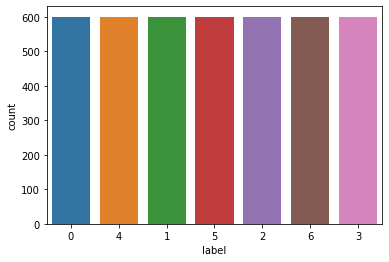

In [101]:
_ = sns.countplot(y_label.label, order = y_label['label'].value_counts().index)

In [102]:
data_classification = pd.concat([X_labels,y_label],axis=1)
data_classification.fillna(data_classification['age'].mean(),inplace=True)

In [103]:
data_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 75 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   female           4200 non-null   int64  
 1   male             4200 non-null   int64  
 2   abdomen          4200 non-null   int64  
 3   acral            4200 non-null   int64  
 4   back             4200 non-null   int64  
 5   chest            4200 non-null   int64  
 6   ear              4200 non-null   int64  
 7   face             4200 non-null   int64  
 8   foot             4200 non-null   int64  
 9   genital          4200 non-null   int64  
 10  hand             4200 non-null   int64  
 11  lower extremity  4200 non-null   int64  
 12  neck             4200 non-null   int64  
 13  scalp            4200 non-null   int64  
 14  trunk            4200 non-null   int64  
 15  unknown          4200 non-null   int64  
 16  upper extremity  4200 non-null   int64  
 17  confocal      

#### Classification Setup

In [104]:
classification_setup = setup(data= data_classification, target='label')

#### Finding accuracy of XgBoost Classifier on the data

In [105]:
xgb_model = create_model('xgboost')

#### Accuracy of 94%!  Lets use XgBoost Classifier

#### Defining parameters for the classifier

In [106]:
params = {
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'learning_rate': 0.1, 
    'max_delta_step': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'missing': None, 
    'n_estimators': 100,
    'n_jobs': -1, 
    'nthread': None,
    'random_state': 1855, 
    'reg_alpha': 0,
    'reg_lambda': 1, 
    'scale_pos_weight': 1,
    'seed': None, 
    'silent': None, 
    'subsample': 1,
    'verbosity': 0,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 7,
    # Set number of GPUs if available   
    'n_gpus': 0,
    'predictor': 'gpu_predictor'
}

clf = xgb.XGBClassifier(**params)

#### Splitting the data

In [107]:
X_train,X_test,y_train,y_test = train_test_split(X_labels,y_label,train_size=0.8,random_state=40)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3360, 74), (3360, 1), (840, 74), (840, 1))

In [108]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_gpus=0, n_jobs=-1, nthread=2, num_class=7,
              num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', random_state=1855, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1855, silent=None,
              subsample=1, ...)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encode

In [110]:
y_pred = clf.predict(X_test)

#### Classification report of XgBoost Classifier

In [111]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(y_test, y_pred, target_names=targetnames))

              precision    recall  f1-score   support

       akiec       0.97      0.95      0.96       121
         bcc       0.93      0.98      0.96       117
         bkl       0.94      0.91      0.93       112
          df       1.00      1.00      1.00       120
         mel       0.90      0.94      0.92       127
          nv       0.93      0.87      0.90       122
        vasc       0.98      1.00      0.99       121

    accuracy                           0.95       840
   macro avg       0.95      0.95      0.95       840
weighted avg       0.95      0.95      0.95       840



#### Confusion Matrix of XgBoost Classifier

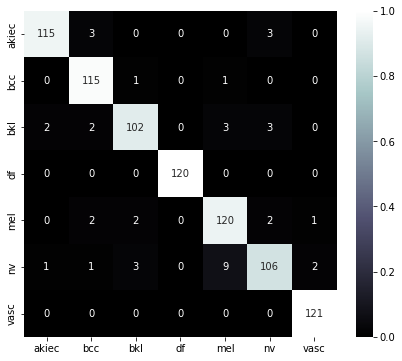

In [112]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, targetnames)

## Step3: Classifying Images

In [114]:
features = ['female', 'male', 'abdomen', 'acral', 'back', 'chest', 'ear','face', 'foot', 'genital', 'hand', 'lower extremity', 'neck','scalp', 'trunk', 'unknown', 'upper extremity', 'confocal','consensus', 'follow up', 'histo', 'age']

In [119]:
cols = ['female', 'male', 'abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk', 'unknown', 'upper extremity', 'confocal', 'consensus', 'follow_up', 'histo', 'age', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51']

In [121]:
diseases = ['Basal cell carcinoma','Actinic keratoses','Benign keratosis-like lesions','Dermatofibroma','Melanocytic nevi','Melanoma','Vascular lesions']

In [115]:
# json_file = open('model2.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

loaded_model = load_model('Second_InceptionV3_model.h5')
print("Loaded CNN Model")
loaded_model.load_weights("model2_weights.h5")
print("Loaded Weights")

Loaded CNN Model
Loaded Weights


#### Image1

In [122]:
name = 'Tina Danes'
age = 33
gender = 'female'
typ = 'histo'
localization = 'foot'
image_path = '../input/data-ham10000/Dataverse/all_segmented_images/ISIC_0024482_masked.png'

Name:  Tina Danes
Model Loaded
Parameters:  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 33]
Image Feature Predictions:  [ 0.96858263  0.43758494  0.08874241 -1.514721    0.09167787  0.2202006
 -0.4652876  -0.5706097  -0.5122509   1.4183054   1.021569    1.0286165
  1.1969395   1.4322532  -1.2313788   1.2693468  -0.24604347 -0.5352905
 -0.6580653  -1.0649211  -2.0546691   1.7884241   0.59903014 -0.6874276
  1.3653545  -0.84474546 -0.9198844   1.7212008  -1.6078804  -0.30201772
 -1.1761954  -0.6569331   0.32883716 -0.7314719  -0.95740247 -0.6732873
  0.35065463  1.6668105   1.0802058  -1.3165938  -0.29499978  1.250677
  0.8359464   0.9074948   1.1419497  -0.30927226 -1.1283668   1.3098228
 -1.1785159   0.9791473   0.25950485  0.20965374]
All Parameters:  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 33, 0.96858263, 0.43758494, 0.088742405, -1.514721, 0.091677874, 0.2202006, -0.4652876, -0.5706097, -0.5122509, 1.4183054, 1.021569, 1.0286165, 1.1969395

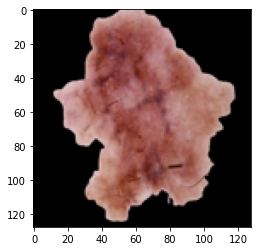

In [123]:
parameters = [0]*len(features)
try:
    parameters[features.index(gender.lower())] = 1
except:
    pass
print("Name: ",name)
print("======================================================================================")

parameters[features.index('age')] = age
parameters[features.index(typ.lower())] = 1
parameters[features.index(localization.lower())] = 1

print('Model Loaded')
print("======================================================================================")

img = Image.open(image_path).resize((128,128))
img = np.asarray(img)
plt.imshow(img)
img = img.reshape(-1,128,128,3)
img = img/255

print("Parameters: ", parameters)
print("======================================================================================")

pred = loaded_model.predict(img)
print("Image Feature Predictions: ", pred[0])
print("======================================================================================")

parameters.extend(list(pred[0]))
print("All Parameters: ", parameters)
print("======================================================================================")

temp_dict = dict(zip(cols,parameters),index=[0])
temp_df = pd.DataFrame(temp_dict)
temp_df = temp_df.drop(['index'],axis=1)
print("Feature Parameters: ", temp_df.head(n=1))
print("======================================================================================")

preds = clf.predict_proba(temp_df)
preds = list(preds[0])
preds = [int(x*100) for x in preds]
print("All Predictions: ", preds)
print("======================================================================================")

data_df = pd.DataFrame(list(zip(diseases,preds)),columns=['disease','preds'])
data_df.sort_values(by=['preds'],ascending = False , inplace = True)
data = {
    'disease' : data_df['disease'].tolist()[:3],
    'prob' : data_df['preds'].tolist()[:3]
}

print("Disease Predictions: ", data)

#### Image2

In [124]:
name = 'Joe Linx'
age = 24
gender = 'male'
typ = 'consensus'
localization = 'chest'
image_path = '../input/data-ham10000/Dataverse/reorganized_segmented_images/vasc/ISIC_0025680_masked.png'

Name:  Joe Linx
Model Loaded
Parameters:  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 24]
Image Feature Predictions:  [ 1.3619127   0.31710202  2.3238292  -0.38962623 -0.4185906  -0.21654347
  1.6412206  -1.4491508   2.6122365  -1.4889464  -0.09576829 -0.01587567
 -0.805163   -0.902556   -0.14438865  1.425068    0.4558786   0.47522792
 -0.21779859 -0.26198694  0.56931835 -1.2758304   1.3731762  -0.3388644
 -1.8337212   0.76958936 -1.4185741   1.0137813  -0.23680782 -0.01743563
  0.10924712 -0.9524391   0.0257293  -0.8466855  -0.8269619   0.23476145
 -1.295446   -0.15945485 -1.1061375  -0.93470275  2.3032267   1.2479959
 -0.5965706   1.0392995  -1.7866278  -0.8497915   0.43514726 -1.742654
  0.86468804 -0.7874713   0.5925523  -1.3592691 ]
All Parameters:  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 24, 1.3619127, 0.31710202, 2.3238292, -0.38962623, -0.4185906, -0.21654347, 1.6412206, -1.4491508, 2.6122365, -1.4889464, -0.09576829, -0.015875667, -0

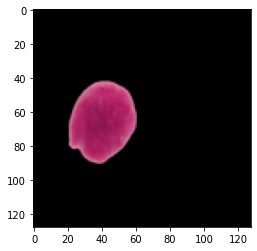

In [125]:
parameters = [0]*len(features)
try:
    parameters[features.index(gender.lower())] = 1
except:
    pass
print("Name: ",name)
print("======================================================================================")

parameters[features.index('age')] = age
parameters[features.index(typ.lower())] = 1
parameters[features.index(localization.lower())] = 1

print('Model Loaded')
print("======================================================================================")

img = Image.open(image_path).resize((128,128))
img = np.asarray(img)
plt.imshow(img)
img = img.reshape(-1,128,128,3)
img = img/255

print("Parameters: ", parameters)
print("======================================================================================")

pred = loaded_model.predict(img)
print("Image Feature Predictions: ", pred[0])
print("======================================================================================")

parameters.extend(list(pred[0]))
print("All Parameters: ", parameters)
print("======================================================================================")

temp_dict = dict(zip(cols,parameters),index=[0])
temp_df = pd.DataFrame(temp_dict)
temp_df = temp_df.drop(['index'],axis=1)
print("Feature Parameters: ", temp_df.head(n=1))
print("======================================================================================")

preds = clf.predict_proba(temp_df)
preds = list(preds[0])
preds = [int(x*100) for x in preds]
print("All Predictions: ", preds)
print("======================================================================================")

data_df = pd.DataFrame(list(zip(diseases,preds)),columns=['disease','preds'])
data_df.sort_values(by=['preds'],ascending = False , inplace = True)
data = {
    'disease' : data_df['disease'].tolist()[:3],
    'prob' : data_df['preds'].tolist()[:3]
}

print("Disease Predictions: ", data)

#### Image3

In [138]:
name = 'Jessie Lorie'
age = 56
gender = 'female'
typ = 'confocal'
localization = 'back'
image_path = '../input/data-ham10000/Dataverse/reorganized_segmented_images/nv/ISIC_0024335_masked.png'

Name:  Jessie Lorie
Model Loaded
Parameters:  [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 56]
Image Feature Predictions:  [ 0.342166    0.06782529 -0.02375638  1.3759392  -0.15985394  0.68609136
  1.1287624   0.6591486  -0.09102035 -0.4529743   1.0613084  -1.0473431
 -0.5835895  -0.3815894   0.85662866 -0.07693908 -0.27511206  0.53600395
 -0.06698924  1.5183314   0.25220048  0.36857095  0.08077323  0.84637356
 -0.50850683 -0.7991973  -0.09823769 -0.47270656  0.907968    0.8114163
 -0.2223312   1.0054085  -0.8676559   1.234533    0.17443961 -1.1478287
  0.29501963 -0.2802988  -0.28192022 -0.00599355 -0.27033216 -0.11626574
  0.7553985  -0.40946257 -0.32982635  1.6367043   1.2383413  -0.30246428
  0.9388476  -0.8814138  -0.6623335   0.42895195]
All Parameters:  [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 56, 0.342166, 0.06782529, -0.023756385, 1.3759392, -0.15985394, 0.68609136, 1.1287624, 0.6591486, -0.091020346, -0.4529743, 1.0613084, -1.0473431,

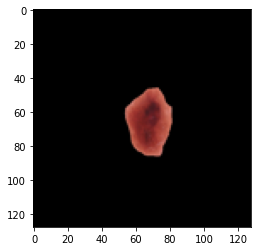

In [139]:
parameters = [0]*len(features)
try:
    parameters[features.index(gender.lower())] = 1
except:
    pass
print("Name: ",name)
print("======================================================================================")

parameters[features.index('age')] = age
parameters[features.index(typ.lower())] = 1
parameters[features.index(localization.lower())] = 1

print('Model Loaded')
print("======================================================================================")

img = Image.open(image_path).resize((128,128))
img = np.asarray(img)
plt.imshow(img)
img = img.reshape(-1,128,128,3)
img = img/255

print("Parameters: ", parameters)
print("======================================================================================")

pred = loaded_model.predict(img)
print("Image Feature Predictions: ", pred[0])
print("======================================================================================")

parameters.extend(list(pred[0]))
print("All Parameters: ", parameters)
print("======================================================================================")

temp_dict = dict(zip(cols,parameters),index=[0])
temp_df = pd.DataFrame(temp_dict)
temp_df = temp_df.drop(['index'],axis=1)
print("Feature Parameters: ", temp_df.head(n=1))
print("======================================================================================")

preds = clf.predict_proba(temp_df)
preds = list(preds[0])
preds = [int(x*100) for x in preds]
print("All Predictions: ", preds)
print("======================================================================================")

data_df = pd.DataFrame(list(zip(diseases,preds)),columns=['disease','preds'])
data_df.sort_values(by=['preds'],ascending = False , inplace = True)
data = {
    'disease' : data_df['disease'].tolist()[:3],
    'prob' : data_df['preds'].tolist()[:3]
}

print("Disease Predictions: ", data)

In [140]:
clf.save_model('Xgboost_classifier.json')

In [142]:
test_model = xgb.XGBClassifier()
test_model.load_model("Xgboost_classifier.json")

#### Image4

In [143]:
name = 'Jessie Lorie'
age = 56
gender = 'female'
typ = 'confocal'
localization = 'back'
image_path = '../input/data-ham10000/Dataverse/reorganized_segmented_images/nv/ISIC_0024335_masked.png'

Name:  Jessie Lorie
Model Loaded
Parameters:  [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 56]
Image Feature Predictions:  [ 0.342166    0.06782529 -0.02375638  1.3759392  -0.15985394  0.68609136
  1.1287624   0.6591486  -0.09102035 -0.4529743   1.0613084  -1.0473431
 -0.5835895  -0.3815894   0.85662866 -0.07693908 -0.27511206  0.53600395
 -0.06698924  1.5183314   0.25220048  0.36857095  0.08077323  0.84637356
 -0.50850683 -0.7991973  -0.09823769 -0.47270656  0.907968    0.8114163
 -0.2223312   1.0054085  -0.8676559   1.234533    0.17443961 -1.1478287
  0.29501963 -0.2802988  -0.28192022 -0.00599355 -0.27033216 -0.11626574
  0.7553985  -0.40946257 -0.32982635  1.6367043   1.2383413  -0.30246428
  0.9388476  -0.8814138  -0.6623335   0.42895195]
All Parameters:  [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 56, 0.342166, 0.06782529, -0.023756385, 1.3759392, -0.15985394, 0.68609136, 1.1287624, 0.6591486, -0.091020346, -0.4529743, 1.0613084, -1.0473431,

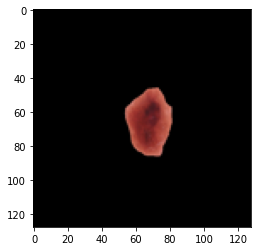

In [144]:
parameters = [0]*len(features)
try:
    parameters[features.index(gender.lower())] = 1
except:
    pass
print("Name: ",name)
print("======================================================================================")

parameters[features.index('age')] = age
parameters[features.index(typ.lower())] = 1
parameters[features.index(localization.lower())] = 1

print('Model Loaded')
print("======================================================================================")

img = Image.open(image_path).resize((128,128))
img = np.asarray(img)
plt.imshow(img)
img = img.reshape(-1,128,128,3)
img = img/255

print("Parameters: ", parameters)
print("======================================================================================")

pred = loaded_model.predict(img)
print("Image Feature Predictions: ", pred[0])
print("======================================================================================")

parameters.extend(list(pred[0]))
print("All Parameters: ", parameters)
print("======================================================================================")

temp_dict = dict(zip(cols,parameters),index=[0])
temp_df = pd.DataFrame(temp_dict)
temp_df = temp_df.drop(['index'],axis=1)
print("Feature Parameters: ", temp_df.head(n=1))
print("======================================================================================")

preds = test_model.predict_proba(temp_df)
preds = list(preds[0])
preds = [int(x*100) for x in preds]
print("All Predictions: ", preds)
print("======================================================================================")

data_df = pd.DataFrame(list(zip(diseases,preds)),columns=['disease','preds'])
data_df.sort_values(by=['preds'],ascending = False , inplace = True)
data = {
    'disease' : data_df['disease'].tolist()[:3],
    'prob' : data_df['preds'].tolist()[:3]
}

print("Disease Predictions: ", data)

<h3><a href="Second_InceptionV3_model.h5"> Download Second InceptionV3 Model for predicting 52 features of an image </a></h3>

<h3><a href="model2.json"> Download Second InceptionV3 Model for predicting 52 features of an image in JSON format</a></h3>

<h3><a href="model2_weights.h5"> Download Model Weights for predicting 52 features of an image </a></h3>

<h3><a href="Xgboost_classifier.json"> Download Xgboost Classifier in JSON format</a></h3>